In [31]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy
import joblib

from IPython.display import clear_output

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice, generate_time_one_time_two

In [2]:
config = Config("config.yaml")

In [3]:
rng = np.random.default_rng(123)

num_timesteps = 1_000
final_time = 1
initial_price = 1
decomp_dim = 1
num_episodes = 10_000
kernel_batch_size = 256

dt = final_time / num_timesteps

# kernel_function = lambda x,y: ((np.abs((x-y))+(dt))**(0.51-1))/scipy.special.gamma(0.51)
# kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
# kernel_function = lambda x, y: 1 / (1 + np.abs(x - y) ** 0.5)
K0 = kernel_function(0, 0)

# Generate Data

# NN Approach

In [4]:
learning_rate = 1e-4
network = MLP(decomp_dim=decomp_dim, learn_price_impact=True)

optimizer = torch.optim.Adam(params=network.kernel_func.parameters(), lr=learning_rate)

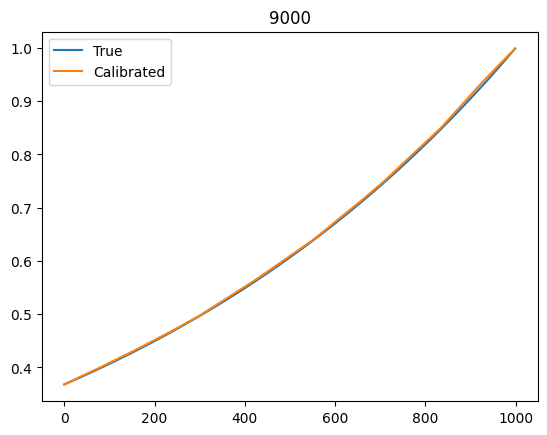

In [5]:
loss_list = []
for i in tqdm(range(num_episodes)):

    time_one = torch.FloatTensor([num_timesteps]).reshape(-1, 1) * dt
    # time_one = (
    #     torch.FloatTensor([rng.uniform(0, num_timesteps)]).reshape(-1, 1) * dt
    # )
    time_two = torch.FloatTensor([rng.uniform(0, num_timesteps)]).reshape(-1, 1) * dt

    K_one_two = network.approx_func(time_one, time_two).flatten()
    K_one_one = network.approx_func(time_one, time_one).flatten()

    true_val = torch.FloatTensor(
        kernel_function(time_one.detach().numpy(), time_two.detach().numpy())
    ).flatten()

    true_error = torch.abs(true_val - K_one_two)
    one_error = torch.abs(K0 - K_one_one)

    delta = torch.FloatTensor(
        rng.uniform(-num_timesteps, num_timesteps, (kernel_batch_size, 1))
    )
    K_one_two_delta = network.approx_func(time_one + delta, time_one + delta).flatten()
    translation_error = torch.abs(K_one_two - K_one_two_delta)

    loss_tensor = torch.hstack(
        [
            (true_error**2).mean(),
            # (one_error**2).mean(),
            # (translation_error**2).mean()
        ]
    )

    loss = loss_tensor.mean()

    loss_list.append(loss.detach().item())

    network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(network.kernel_func.parameters(), 1)
    optimizer.step()

    network.zero_grad()
    optimizer.zero_grad()

    if i % 1000 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        for _ in range(0, int(s_val)):
            k_s_t = network.approx_func(
                torch.FloatTensor([s_val * dt]).reshape(-1, 1),
                torch.FloatTensor([_ * dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        for _ in range(0, int(s_val)):
            val = kernel_function(_ * dt, s_val * dt)
            kernel_plot_two.append(val)

        plt.title(i)
        plt.plot(kernel_plot_two, label="True")
        plt.plot(kernel_plot, label="Calibrated")
        plt.legend()
        plt.show()

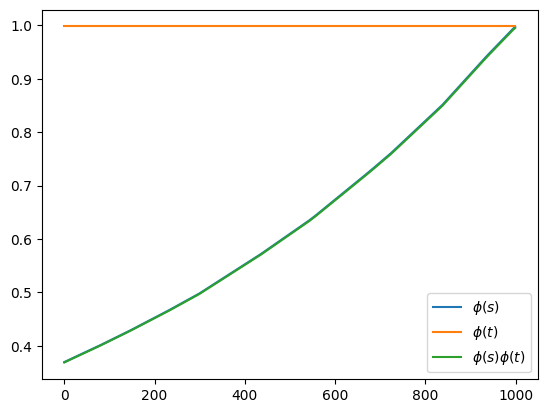

In [6]:
s_val = 1
final_timesteps = int(num_timesteps * s_val)
kernel_plot = []
kernel_plot_two = []
kernel_plot_three = []

for i in range(-final_timesteps, 0):
    k_s_t = network(torch.FloatTensor([num_timesteps * dt]))
    k_s_t_two = network(torch.FloatTensor([num_timesteps * dt + i * dt]))

    k_s_t_three = network.approx_func(
        torch.FloatTensor([num_timesteps * dt]).reshape(-1, 1),
        torch.FloatTensor([num_timesteps * dt + i * dt]).reshape(1, -1),
    )

    kernel_plot.append(k_s_t.detach().numpy())
    kernel_plot_two.append(k_s_t_two.detach().numpy())
    kernel_plot_three.append(k_s_t_three.detach().numpy())

plt.plot(kernel_plot_two, label=r"$\phi(s)$")
plt.plot(kernel_plot, label=r"$\phi(t)$")
plt.plot(kernel_plot_three, label=r"$\phi(s) \phi(t)$")
plt.legend()
plt.show()

# Solving HJB Equation

In [7]:
def phi_s(network, final_time, t_time, s_time):

    assert s_time <= t_time

    return (
        network(torch.FloatTensor([(final_time + s_time - t_time)]))
        .detach()
        .numpy()
        .flatten()
    )


def phi_prime_s(network, final_time, t_time, s_time, dt):

    return 1

    # return abs(
    #     (
    #         network(
    #             torch.FloatTensor([final_time + s_time - t_time])
    #             - network(torch.FloatTensor([final_time + s_time - t_time - dt]))
    #         )
    #         / (dt)
    #     )
    #     .detach()
    #     .numpy()
    #     .flatten()
    # )

def h_t(h_t_plus_one, delta_t_h, dt):

    h_t = h_t_plus_one - delta_t_h * dt

    return h_t

def k_dot_G_q(network, final_time, time, G, q, dt):

    k_dot = phi_prime_s(network, final_time, t_time=1, s_time=1, dt=dt)

    return_val = k_dot * np.outer(G, q)

    return return_val


def phi_q_squared(phi, q):

    return phi * (q**2)

def partial_h_q(h_t_plus_one, dq):

    delta_h_q = np.zeros_like(h_t_plus_one)

    middle = h_t_plus_one[:, 1:-1] - h_t_plus_one[:, 0:-2]

    delta_h_q[:, 1:-1] = middle / (dq)

    h_q_lower = 2 * h_t_plus_one[:, 0] - h_t_plus_one[:, 1]
    delta_h_q_lower = h_t_plus_one[:, 0] - h_q_lower

    h_q_upper = 2 * h_t_plus_one[:, -1] - h_t_plus_one[:, -2]
    delta_q_upper = h_q_upper - h_t_plus_one[:, -1]

    delta_h_q[:, 0] = delta_h_q_lower / (dq)
    delta_h_q[:, -1] = delta_q_upper / (dq)

    return delta_h_q

def partial_h_G(h_t_plus_one, dG):

    delta_h_G = np.zeros_like(h_t_plus_one)

    middle = h_t_plus_one[1:-1, :] - h_t_plus_one[0:-2, :]

    delta_h_G[1:-1] = middle / dG

    h_G_lower = 2 * h_t_plus_one[0, :] - h_t_plus_one[1, :]
    delta_h_G_lower = h_t_plus_one[0, :] - h_G_lower

    h_G_upper = 2 * h_t_plus_one[-1, :] - h_t_plus_one[-2, :]
    delta_h_G_upper = h_G_upper - h_t_plus_one[-1, :]

    delta_h_G[0, :] = delta_h_G_lower / dG
    delta_h_G[-1, :] = delta_h_G_upper / dG

    return delta_h_G

def y(h_t_plus_one, q, k_t_plus_one, b, kappa, dq, dG):

    term_one = b * q.reshape(1, -1)

    delta_h_G = partial_h_G(h_t_plus_one=h_t_plus_one, dG=dG)
    delta_h_q = partial_h_q(h_t_plus_one=h_t_plus_one, dq=dq)

    term_three = delta_h_q

    term_four = term_three + term_one

    term_two = b * k_t_plus_one * delta_h_G

    return -(term_four+term_two)

def xi(a, kappa):

    return (a * kappa) / (((1 + a) * kappa) ** (1 + 1 / a))

def F_star(xi, y, a):

    return xi * (y ** (1 + 1 / a))

def F_star_term(h_t_plus_one, q, k_t_plus_one, a, b, kappa, dq, dG):

    y_term = y(
        h_t_plus_one=h_t_plus_one, q=q, kappa=kappa, k_t_plus_one=k_t_plus_one, b=b, dq=dq, dG=dG
    )

    xi_term = xi(a=a, kappa=kappa)

    F_star_term_var = F_star(xi=xi_term, y=y_term, a=a)

    return F_star_term_var

def rhs(h_t_plus_one, time, q, G, k_t_plus_one, phi, a, b, kappa, dq, dG, dt, network):

    k_dot_G_q_term = k_dot_G_q(
        network=network, final_time=1, time=time, G=G, q=q, dt=dt
    )

    phi_q_squared_term = phi_q_squared(phi=phi, q=q)

    f_star_term = F_star_term(
        h_t_plus_one=h_t_plus_one,
        q=q,
        k_t_plus_one=k_t_plus_one,
        a=a,
        b=b,
        kappa=kappa,
        dq=dq,
        dG=dG,
    )

    return k_dot_G_q_term + phi_q_squared_term.reshape(1,-1) - f_star_term

# Solve equation

In [29]:
q_val_dict = {}

num_timesteps = 100_000
final_time = 1
dt = final_time/num_timesteps
timesteps = np.arange(0, final_time+dt, dt)

a_vals = (0.8, 1, 2, 5)

for a in a_vals:
    kappa = 0.001
    b = 0.001
    phi = 10 * kappa
    alpha = 100 * kappa

    G_lower = -b*1.1
    G_upper = b*1.1
    num_G_steps = 100
    dG = G_upper/num_G_steps
    G_grid = np.arange(G_lower-dG, G_upper+dG, dG)

    q_lower = 0
    q_upper = 1
    num_q_steps = 100
    dq = q_upper/num_q_steps
    q_grid = np.arange(q_lower, 1+dq, dq)

    # [time, G, q]
    h_grid = np.zeros((num_timesteps, len(G_grid), len(q_grid)))
    nu_star = np.zeros((num_timesteps, len(G_grid), len(q_grid)))

    # Initialize terminal condition
    h_grid[-1, :, :] = -alpha * (q_grid**2)

    for i in tqdm(range(1, num_timesteps)):

        time = (num_timesteps - i) * dt

        h_t_plus_one = h_grid[num_timesteps - i]

        delta_t_h = rhs(
            h_t_plus_one=h_t_plus_one,
            time=1,
            q=q_grid,
            G=G_grid,
            # k_t_plus_one=phi_s(network=network,final_time=1, t_time=1, s_time=time),
            k_t_plus_one=1,
            a=a,
            b=b,
            kappa=kappa,
            phi=phi,
            network=network,
            dq=dq,
            dG=dG,
            dt=dt,
        )

        h_t_term = h_t_plus_one - delta_t_h*dt

        h_grid[num_timesteps - (i + 1)] = h_t_term

        y_term = y(
            h_t_plus_one=h_t_plus_one,
            q=q_grid,
            k_t_plus_one=abs(phi_s(network=network, final_time=1, t_time=1, s_time=1)),
            # k_t_plus_one=1,
            b=b,
            kappa=kappa,
            dq=dq,
            dG=dG,
        )

        nu_star[num_timesteps - (i + 1)] = ((y_term) / ((1 + a) * kappa)) ** (1 / a)

    Q = np.ones(num_timesteps)
    for i in range(0, num_timesteps - 1):

        q_index = np.argmin(np.abs(Q[i] - q_grid))

        dQ = - nu_star[i, int(num_G_steps/2), q_index] * dt

        new_term = Q[i] + dQ
    
        Q[i + 1] = new_term

    q_val_dict[int(a*10)] = Q

    # break

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

In [32]:
# joblib.dump(q_val_dict, '../results/OE_with_kernel.joblib')

['../results/OE_with_kernel.joblib']

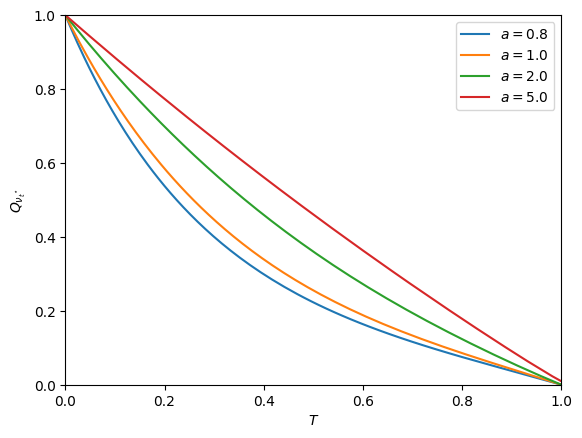

In [44]:
for key, Q in q_val_dict.items():
    plt.plot(np.linspace(0,1, len(Q[Q>0])),Q[Q>0], label=rf'$a={key/10}$')

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.ylabel(r'$Q_{{\nu_t}^{\star}}$')
plt.xlabel(r'$T$')
plt.legend()
plt.show()

In [22]:
Q_one= np.ones(num_timesteps)
for i in range(0, num_timesteps - 1):

    q_index = np.argmin(np.abs(Q_one[i] - q_grid))

    dQ = - nu_star[i, -1, q_index] * dt

    new_term = Q_one[i] + dQ

    Q_one[i + 1] = new_term

Q_two = np.ones(num_timesteps)
for i in range(0, num_timesteps - 1):

    q_index = np.argmin(np.abs(Q_two[i] - q_grid))

    dQ = - nu_star[i, 0, q_index] * dt

    new_term = Q_two[i] + dQ

    Q_two[i + 1] = new_term

Q_three = np.ones(num_timesteps)
for i in range(0, num_timesteps - 1):

    q_index = np.argmin(np.abs(Q_three[i] - q_grid))

    dQ = - nu_star[i, int(num_G_steps/2), q_index] * dt

    new_term = Q_three[i] + dQ

    Q_three[i + 1] = new_term

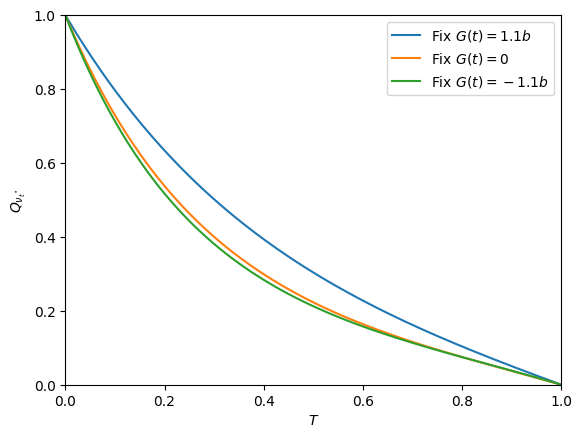

In [43]:
# plt.plot(Q_one, label=r'Fix $G(t)=1.1b$')
plt.plot(np.linspace(0,1, len(Q_one[Q_one>0])),
         Q_one[Q_one>0], 
         label=r'Fix $G(t)=1.1b$')

# plt.plot(Q_three, label=r'Fix $G(t)=0$')
plt.plot(np.linspace(0,1, len(Q_three[Q_three>0])),
         Q_three[Q_three>0], 
         label=r'Fix $G(t)=0$')

# plt.plot(Q_two, label=r'Fix $G(t)=-1.1b$')
plt.plot(np.linspace(0,1, len(Q_two[Q_two>0])),
         Q_two[Q_two>0], 
         label=r'Fix $G(t)=-1.1b$')

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.ylabel(r'$Q_{{\nu_t}^{\star}}$')
plt.xlabel(r'$T$')
plt.legend()
plt.show()